# Green Tensor of a Cavity

We analyze the Green tensor of a cavity, which gives insight into how a cavity does change the interactions between two atoms.


In [ ]:
# %pip install -q pairinteraction # Uncomment for installation on Colab
# Uncomment the next line if you have ipympl installed and want interactive plots
# %matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import pairinteraction as pi
from pairinteraction.green_tensor import GreenTensorCavity
from pairinteraction.green_tensor.green_tensor_free_space import GreenTensorFreeSpace

We focus here on the transition between two circular Rydberg states.
In the following the lifetime, C3 coefficient and the transition wavelength are calculated for reference.

In [2]:
n = 30
ket1 = pi.KetAtom("Sr88_singlet", n=n, l=n - 1, m=n - 1)
ket2 = pi.KetAtom("Sr88_singlet", n=n + 1, l=n, m=n)

print(f"{ket1} - {ket2}")
c3 = pi.C3(ket1, ket2).get().to("planck_constant GHz mum^3")
lifetimes = {str(ket): ket.get_lifetime().to("ms") for ket in [ket1, ket2]}
print(f"  c3={c3}")
print(f"  lifetimes={lifetimes}")

transition_energy = abs(ket1.get_energy() - ket2.get_energy())
wavelength = transition_energy.to("micrometer", "spectroscopy")
wavelength_mum = wavelength.to("micrometer").m
print(f"  transition_energy={transition_energy.to('planck_constant GHz')}")
print(f"  wavelength={wavelength.to('micrometer')}")

|Sr88_singlet:30,29_29,29⟩ - |Sr88_singlet:31,30_30,30⟩
  c3=0.401194815439827 gigahertz * micrometer ** 3 * planck_constant
  lifetimes={'|Sr88_singlet:30,29_29,29⟩': <Quantity(2.19360709, 'millisecond')>, '|Sr88_singlet:31,30_30,30⟩': <Quantity(2.58725834, 'millisecond')>}
  transition_energy=232.02579196980213 gigahertz * planck_constant
  wavelength=1292.0652288475658 micrometer


Now we calculate the Green Tensor for a list of different cavity spacings z.

In [3]:
static_z = 1
z_list = [
    static_z,
    min(10, 0.001 * wavelength_mum),
    0.05 * wavelength_mum,
    0.4 * wavelength_mum,
    0.5 * wavelength_mum,
    0.8 * wavelength_mum,
    np.inf,
]  # mum

V_dict = {}
distance_dict = {}
for i, z in enumerate(z_list):
    print(f"Calculating z {i + 1}/{len(z_list)}", 50 * " ")
    static = bool(z == static_z)

    if np.isinf(z):
        distance_dict[z] = np.logspace(np.log10(0.1), np.log10(10 * wavelength_mum), num=500)
    else:
        distance_dict[z] = np.logspace(np.log10(0.1), np.log10(10 * z), num=100)

    tensor_list = []
    for j, d in enumerate(distance_dict[z]):
        print(f"  Calculating distance {j + 1}/{len(distance_dict[z])}: {d} mum", end="\r")
        if np.isinf(z):
            gt = GreenTensorFreeSpace([0, 0, 0], [d, 0, 0], unit="mum")
        else:
            gt = GreenTensorCavity(
                [0, 0, 0], [d, 0, 0], z1=z / 2, z2=-z / 2, unit="mum", static_limit=static
            )

        tensor = gt.get(1, 1, transition_energy)
        tensor_list.append(tensor)

    V_dict[z] = np.array([np.abs(np.real(tensor[0, 0].m)) for tensor in tensor_list])

Calculating z 1/7                                                   
Calculating z 2/7                                                   
Calculating z 3/7                                                   
Calculating z 4/7                                                   
Calculating z 5/7                                                   
Calculating z 6/7                                                   
Calculating z 7/7                                                   


Now we can plot the different cavity Green Tensor over the interatomic distance.
In a log-log scale as shown here the expected free space, static limit, is a line, corresponding to the $r^{-3}$ behavior.
As one can see, for a cavity, the Green Tensor rapidly decreases for interatomic distances larger than the cavity spacing z (even for distances much smaller than the transition wavelength).
In addition, if the the interatomic distance start to be on the order of the transition wavelength, dynamic effects of the Gren tensor (resulting in peaks) can be seen.

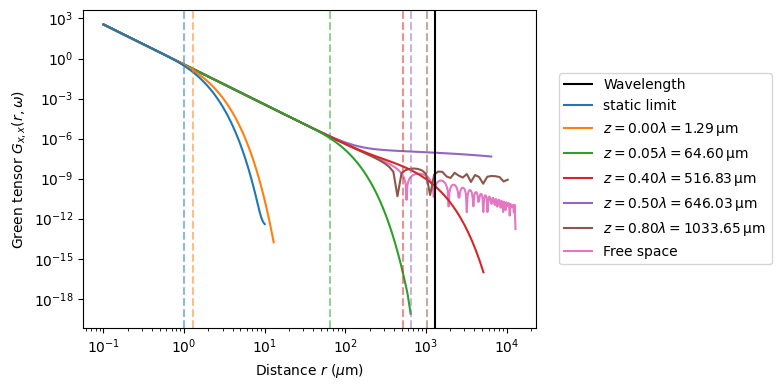

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.axvline(wavelength_mum, color="k", ls="-", label="Wavelength")

for i, (z, V) in enumerate(V_dict.items()):
    color = f"C{i}"
    label = rf"$z = {z / wavelength_mum:.2f} \lambda = {z:.2f} \, \mathrm{{\mu m}}$"
    if np.isinf(z):
        label = r"Free space"
    if z == static_z:
        label = "static limit"

    distance_list = distance_dict[z]
    ax.plot(distance_list, np.real(V), color=color, label=label, zorder=-i)

    ax.axvline(z, color=color, ls="dashed", alpha=0.5)


ax.set_ylabel(r"Green tensor $G_{x,x}(r, \omega)$")
ax.set_xlabel(r"Distance $r$ ($\mu$m)")

ax.set_xscale("log")
ax.set_yscale("log")

ax.legend(loc=(1.05, 0.2))
fig.tight_layout()

plt.show()

We rescale the above plot, to see the similar behaviour for cavities way smaller than the transition wavelength.
For cavities with distances similar to the transition wavelength the behaviour changes significantly.

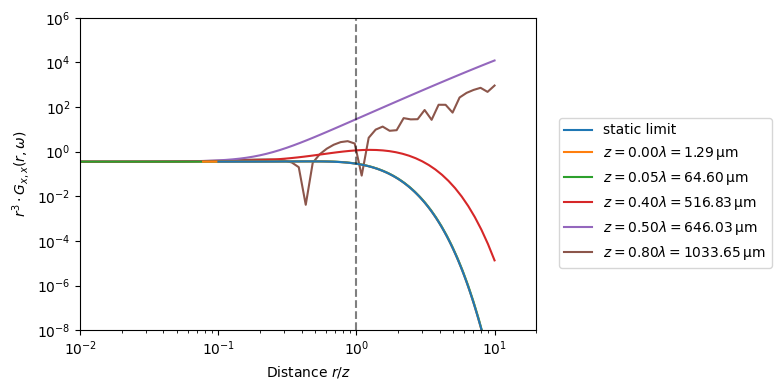

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))

for i, (z, V) in enumerate(V_dict.items()):
    color = f"C{i}"
    label = rf"$z = {z / wavelength_mum:.2f} \lambda = {z:.2f} \, \mathrm{{\mu m}}$"
    if np.isinf(z):
        continue
    if z == static_z:
        label = "static limit"

    distance_list = distance_dict[z]
    ax.plot(
        distance_list / z, np.real(V) * distance_list**3, color=color, label=label, zorder=-i
    )

ax.axvline(1, color="k", ls="dashed", alpha=0.5)

ax.set_ylabel(r"$r^3 \cdot G_{x,x}(r, \omega)$")
ax.set_xlabel(r"Distance $r / z$")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(1e-2, 2e1)
ax.set_ylim(1e-8, 1e6)

ax.legend(loc=(1.05, 0.2))
fig.tight_layout()

plt.show()